# Marginal Effects of Airline Passenger Satisfaction

<p>Deciphering what factors lead to customer satisfaction.</p>

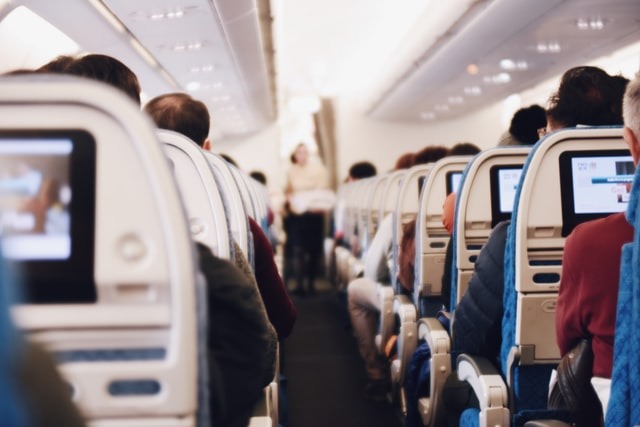
<p><font size="1.5">Photo by <a href="https://unsplash.com/@by_syeoni">Suhyeon Choi</a> on <a href="https://unsplash.com/photos/tTfDMaRq-FE">Unsplash</a> [1].</font></p>

<p>Marginal effects measure the influence a change in an independent variable has on a dependent variable. Interpretation is more natural in a linear OLS model since the estimated coefficient is the marginal effect. However, once we depart from linear models, the coefficient estimates are no longer directly interpretable.</p>
    
<p>In regression analysis, logistic regression is estimating the parameters of a logistic model. Formally, in binary logistic regression, there is a single binary dependent variable, where the two values are labeled "0" and "1". A logit model does not intuitively reflect the relationship between observed outcomes and regressors. In this notebook, we will build a model that will allow us to see interpretable and economically meaningful marginal effects on airline passenger satisfaction.</p>

<p>We'll use the<a href="https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction"> Airline Passenger dataset</a> from Kaggle that contains an airline passenger satisfaction survey. What factors are highly correlated to a satisfied (or dissatisfied) passenger? Can you predict passenger satisfaction? The structure of this notebook is as follows:</p>

<ul>
<li>First, we will start by loading and viewing the datasets.</li>
<li>We will see that the dataset has a mixture of numerical, non-numerical, and categorical features, that it contains values from wide ranges, and we check for missing entries.</li>
<li>After our data is in good shape, we will do some exploratory data analysis to build our intuitions.</li>
<li>We will preprocess the dataset to ensure the model we choose has the features we want to know the marginal effects.</li>
<li>Finally, we will build a logistic regression model that explains how and what factors lead to airline customer satisfaction.</li>
</ul>

## Table of Contents:
1. [Airline Customer Satisfaction data](#a)<br>
2. [Further inspection of data](#b)<br>
3. [Missing Values Checkpoint](#c)<br>
4. [Exploratory Data Analysis (Part 1)](#d)<br>
5. [Exploratory Data Analysis (Part 2)](#e)<br>
6. [Exploratory Data Analysis (Part 3)](#f)<br>
7. [Exploratory Data Analysis (Part 4)](#g)<br>
8. [Preprocess the data](#h)<br>
9. [Updated Summary](#i)<br>
10. [Average Airline Passengers](#j)<br>
11. [Median Airline Passengers](#k)<br>
12. [Modal Airline Passengers](#l)<br>
13. [Correlation with satisfaction](#m)<br>
14. [Setting aside mixes of features](#n)<br>
15. [Splitting the data into X and y](#o)<br>
16. [Fitting the Logistic Regression model](#p)<br>
17. [Mean Marginal Effects](#q)<br>
18. [Median Marginal Effects](#r)<br>
19. [Modal Marginal Effects](#s)<br>
20. [Confidence in Marginal Effect estimation](#t)<br>
21. [Version 2: 15 features](#u)<br>
22. [Version 3: 10 features](#v)<br>
23. [Version 4: 5 features](#w)<br>
24. [Version 5: Top 5 correlations](#x)<br>
25. [Conclusion](#y)<br>
<br>

<a id="a"></a>
## 1| Airline Customer Satisfaction data
<p>We combine the train and test data sets and remove the first column since it doubles as an index. The datasets are concatenated to append the data sets together on their rows. The index is reset and will start at 1 to make tracking the observations easier. At last, we inspect our progress!</p>

In [1]:
# Import the Pandas library
import pandas as pd

# Allow all columns to be seen
pd.set_option('display.max_columns', None)

# Load the two datasets
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

# Remove the first columns
df1 = df1.iloc[: , 1:]
df2 = df2.iloc[: , 1:]

# Append the DataFrames
result = pd.concat([df1, df2])

# Reset the index and have it start at 1
result.reset_index(drop=True,inplace=True)
result.index += 1

# Inspect the data
result.tail()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
129876,78463,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
129877,71167,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,satisfied
129878,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
129879,90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,satisfied
129880,34799,Female,Loyal Customer,42,Personal Travel,Eco,264,2,5,2,5,4,2,2,1,1,2,1,1,1,1,0,0.0,neutral or dissatisfied


<a id="b"></a>
## 2| Further inspection of data
<p>Our data has 129,880 observations of the satisfaction survey. The variables are:</p>
<ul>
<li><code>id</code> - a unique number that identifies each customer.</li>
<li><code>Gender</code> - gender of the passengers (female, Male).</li>
<li><code>Customer Type</code> - the customer type (loyal customer, disloyal customer).</li>
<li><code>Age</code> - the actual age of the passenger.</li>
<li><code>Type of Travel</code> - purpose of the flight of the passengers (Personal Travel, Business Travel).</li>
<li><code>Class</code> - travel class in the plane of the passengers (Business, Eco, Eco Plus).</li>
<li><code>Flight Distance</code> - the flight distance of this journey.</li>
<li><code>Inflight wifi service</code> - satisfaction level of the inflight wifi service (0:Not Applicable;1-5).</li>
<li><code>Departure/Arrival time convenient</code> - satisfaction level of Departure/Arrival time convenient.</li>
<li><code>Ease of Online booking</code> - satisfaction level of online booking.</li>
<li><code>Gate Location</code> - satisfaction level of Gate location.</li>
<li><code>Food and drink</code> - satisfaction level of Food and drink.</li>
<li><code>Online boarding</code> - satisfaction level of online boarding.</li>
<li><code>Inflight entertainment</code> - satisfaction level of inflight entertainment.</li>
<li><code>Seat comfort</code> - satisfaction level of seat comfort.</li>
<li><code>On-board service</code> - satisfaction level of On-board service.</li>
<li><code>Leg room service</code> - satisfaction level of Leg room service.</li>
<li><code>Baggage handling</code> - satisfaction level of Baggage handling.</li>
<li><code>Check-in service</code> - satisfaction level of Check-in service.</li>
<li><code>Inflight service</code> - satisfaction level of Inflight service.</li>
<li><code>Cleanliness</code> - satisfaction level of Cleanliness.</li>
<li><code>Departure Delay in Minutes</code> - minutes delayed when departure.</li>
<li><code>Arrival Delay in Minutes</code> - minutes delayed when Arrival.</li>
<li><code>satisfaction</code> - airline satisfaction level(Satisfaction, neutral or dissatisfaction).</li>
</ul>
<p>As we can see from another glance at the data, the dataset has a mixture of numerical, non-numerical, and categorical features. Let's learn about the dataset a bit more to see if other dataset issues need to be fixed.</p> 

In [2]:
# Print summary statistics
summary = result.describe(include='all')
round(summary, 2)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,129880.00,129880,129880,129880.00,129880,129880,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129487.00,129880
unique,NaN,2,2,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Female,Loyal Customer,NaN,Business travel,Business,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral or dissatisfied
freq,NaN,65899,106100,NaN,89693,62160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73452
mean,64940.50,NaN,NaN,39.43,NaN,NaN,1190.32,2.73,3.06,2.76,2.98,3.20,3.25,3.44,3.36,3.38,3.35,3.63,3.31,3.64,3.29,14.71,15.09,NaN
std,37493.27,NaN,NaN,15.12,NaN,NaN,997.45,1.33,1.53,1.40,1.28,1.33,1.35,1.32,1.33,1.29,1.32,1.18,1.27,1.18,1.31,38.07,38.47,NaN
min,1.00,NaN,NaN,7.00,NaN,NaN,31.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN
25%,32470.75,NaN,NaN,27.00,NaN,NaN,414.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,3.00,3.00,3.00,2.00,0.00,0.00,NaN
50%,64940.50,NaN,NaN,40.00,NaN,NaN,844.00,3.00,3.00,3.00,3.00,3.00,3.00,4.00,4.00,4.00,4.00,4.00,3.00,4.00,3.00,0.00,0.00,NaN
75%,97410.25,NaN,NaN,51.00,NaN,NaN,1744.00,4.00,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,4.00,5.00,4.00,5.00,4.00,12.00,13.00,NaN


In [3]:
# Print DataFrame information
result_info = result.info()
print(result_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 1 to 129880
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

<a id="c"></a>
## 3| Missing Values Checkpoint
<p>By printing the DataFrame information, we find that <code>Arrival Delay in Minutes</code> has several hundred missing values. It is not many, considering we have over 100,000 observations, but we will address the issue.</p>

<p>Our dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code>, and <code>object</code> types). Features 1, 2, 4, 5, and 23 contain object values and all the other features contain numeric values (int64 and float64).</p>

<p>A count of the missing values reveals 393 observations are missing for <code>Arrival Delay in Minutes</code>.  To fix the problem we will impute the missing values with a strategy called mean imputation.</p>   

In [4]:
# Count the amount of missing values
tot_nan = result['Arrival Delay in Minutes'].isnull().sum()
print("Count of NaN:", tot_nan)

# Remove any warnings that distract from analysis
import warnings
warnings.filterwarnings('ignore')

# Impute the missing values with mean imputation
result['Arrival Delay in Minutes'].fillna(result['Arrival Delay in Minutes'].mean(), inplace=True)

# Count the number of NaNs in the datasets and print the counts to verify
print("New count of NaN Arrival Delay in Minutes feature:",result['Arrival Delay in Minutes'].isnull().sum())

Count of NaN: 393
New count of NaN Arrival Delay in Minutes feature: 0


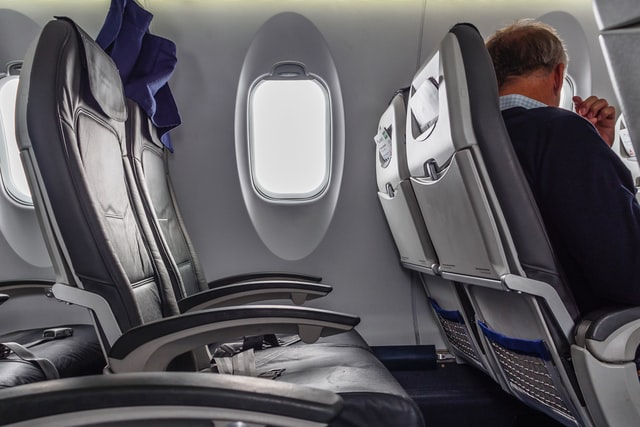
<p><font size="1.5">Photo by <a href="https://unsplash.com/@alschim">Alexander Schimmeck</a> on <a href="https://unsplash.com/photos/HcI3I8mTaQU">Unsplash</a> [2].</font></p>

<a id="d"></a>
## 4| Exploratory Data Analysis (Part 1)
<p>We now can explore distributions and ranges of the features. A histogram is used to display data using bars of different heights. In a histogram, each bar groups numbers into ranges, and taller bars show that more data falls in that range. A histogram displays the shape and spread of continuous sample data. A box plot graphically depicts groups of numerical data through their quartiles. The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). The whiskers extend from the edges of the box to show the range of the data. By default, they rise no more than 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box, ending at the farthest data point within that interval. Outliers are plotted as separate dots.</p>

<p>The distributions are fascinating! We can see the <code>Age</code> of a passenger is mostly between 20 and 60.<code>Flight Distance</code> has a right skew, pointing to outlier flights of over 4,000 miles.</p>

<p><code>Inflight wifi service</code>, <code>Departure/Arrival time convenient</code>, <code>Ease of Online booking</code>, <code>Gate location</code>, <code>Food and drink</code>, <code>Online boarding</code>, <code>Seat comfort</code>, <code>Inflight entertainment</code>, <code>On-board service</code>, <code>Leg room service</code>, <code>Baggage handling</code>, <code>Checkin service</code>, <code>Inflight service</code>, <code>Cleanliness</code> all range from 0 to 5, with few observations at 0.</p>

<p><code>Departure Delay in Minutes</code> and <code>Arrival Delay in Minutes</code> have tight distributions between 0 and 20 minutes.</p>

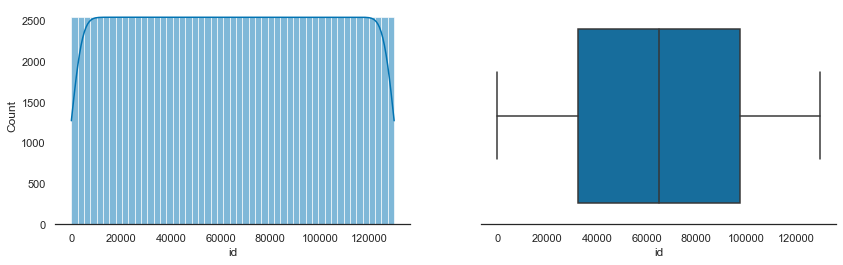

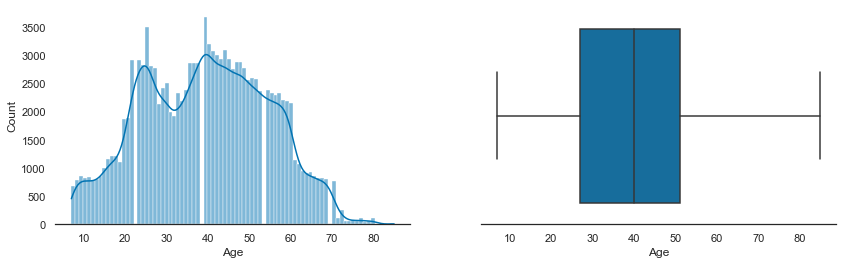

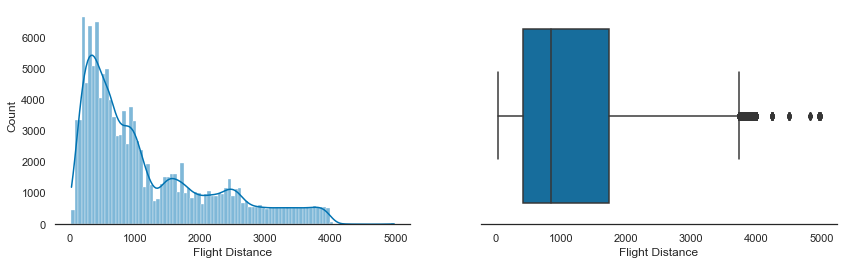

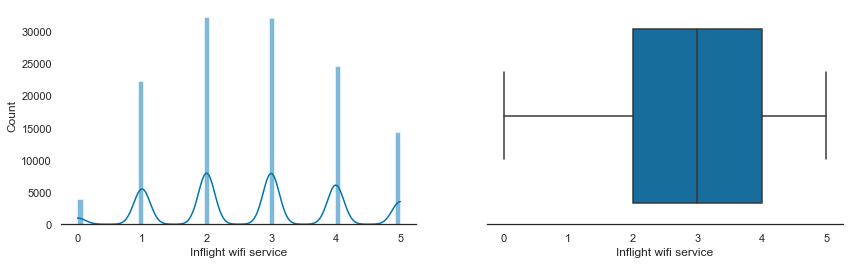

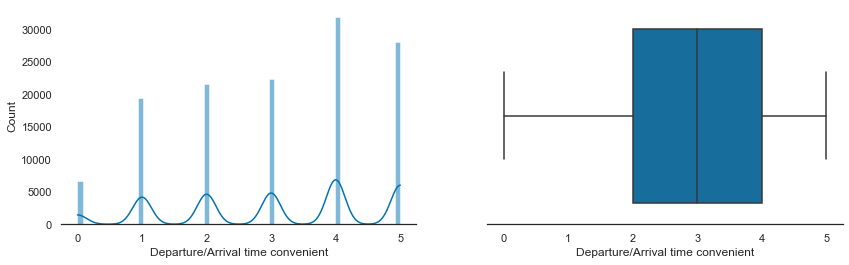

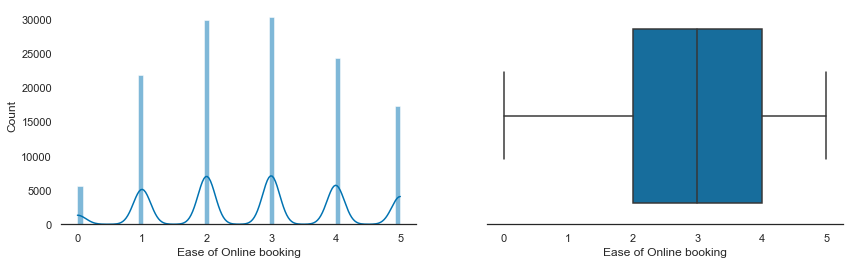

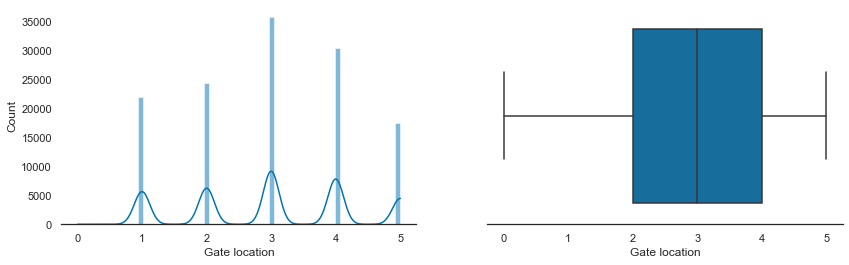

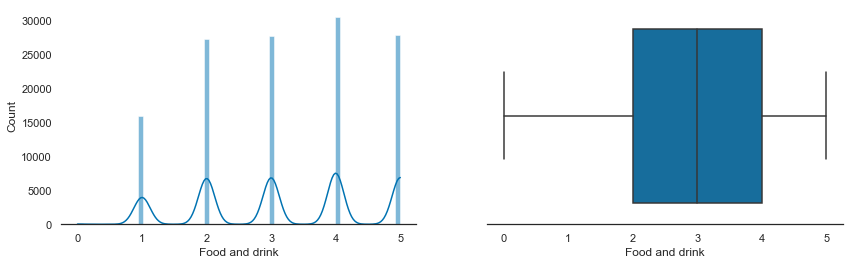

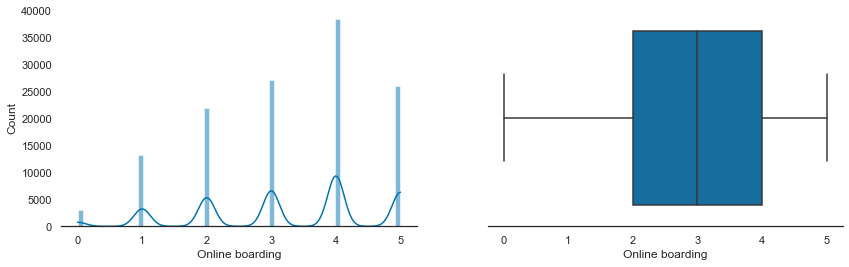

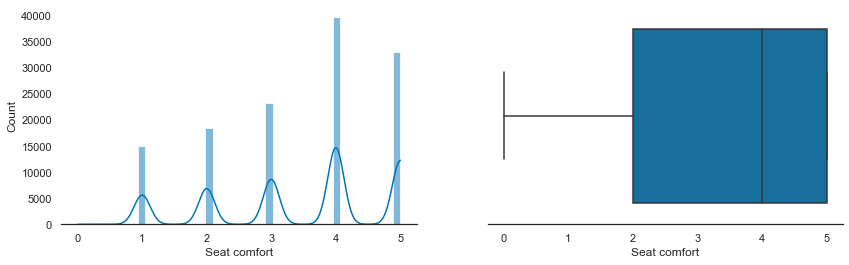

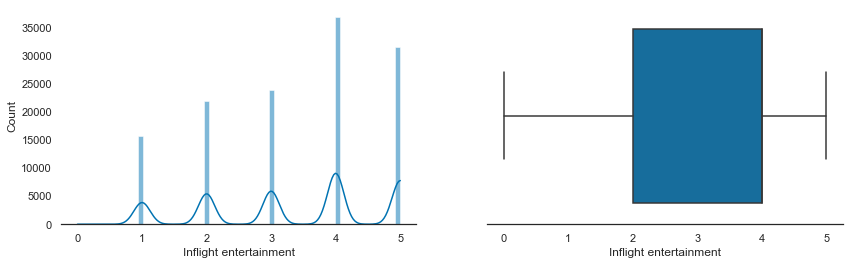

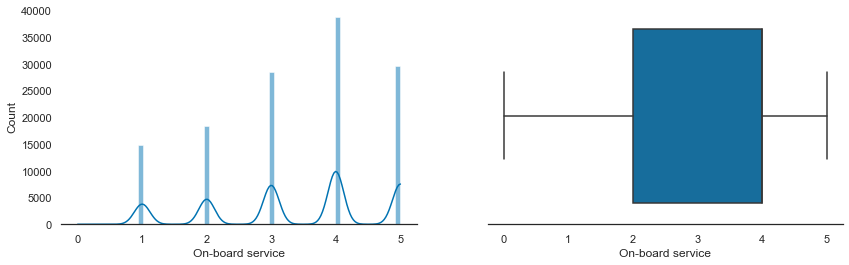

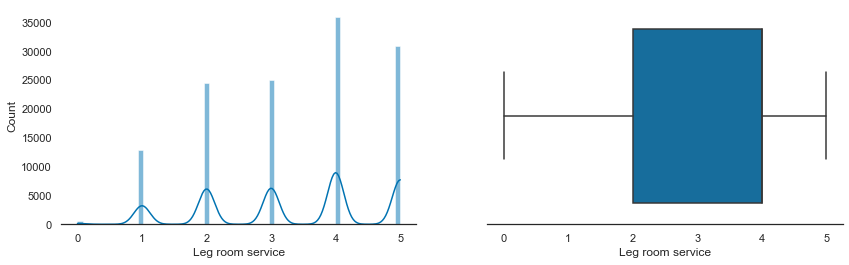

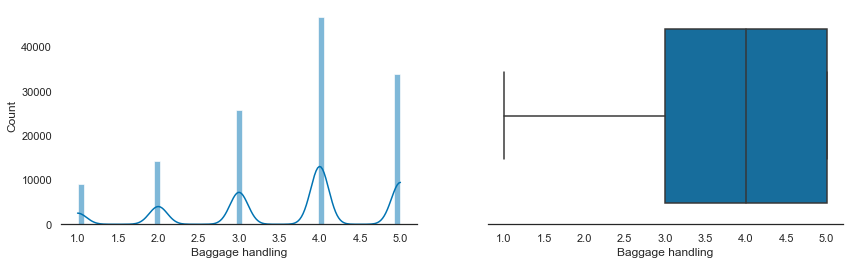

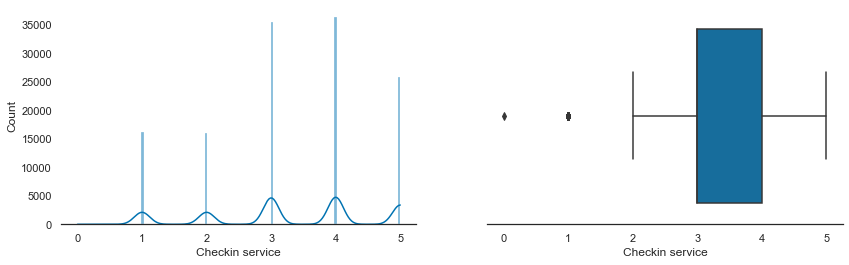

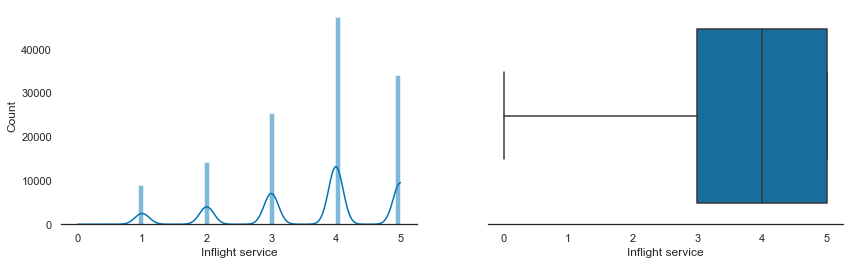

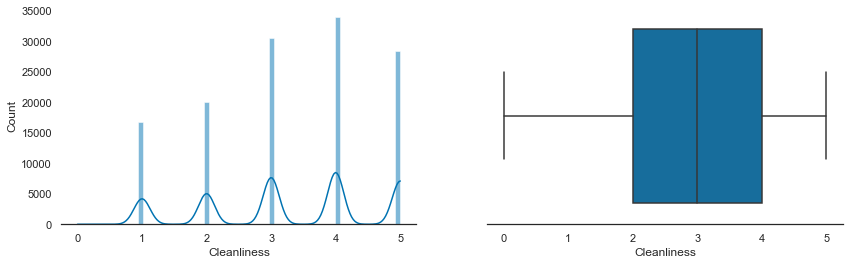

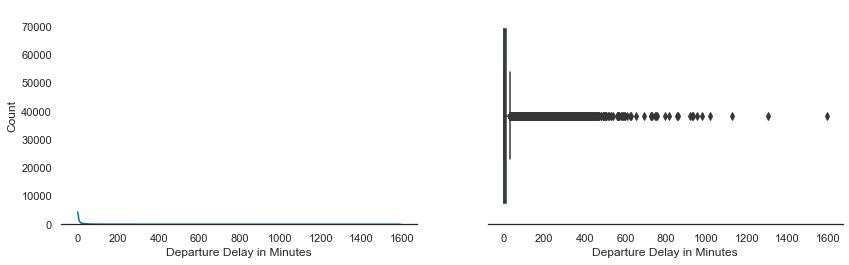

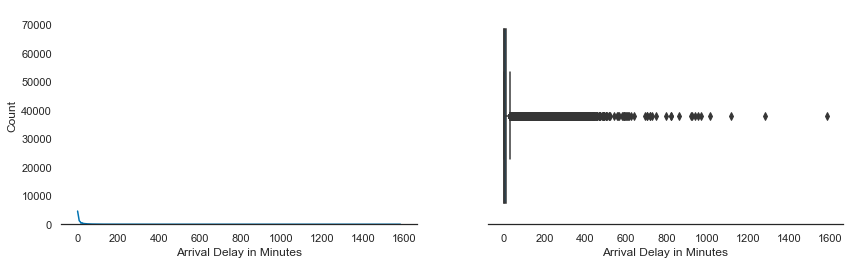

In [5]:
# Import matplotlib, seaborn, and set the style
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white',palette='colorblind')

# Loop over the numerical columns
numerical = result.select_dtypes('number').columns
for col in numerical:
    fig, ax = plt.subplots(1, 2, figsize=(14,4))
    
    # Histogram plot with kde to estimate the probability
    sns.histplot(data=result, x=col, kde=True, ax=ax[0])
    sns.despine(left=True)
    
    # Box plot to get get interquartile range
    sns.boxplot(data=result, x=col, ax=ax[1])

<a id="e"></a>
## 5| Exploratory Data Analysis (Part 2)
<p>Let's further explore the dependent variable and features that are of the object type. That is <code>satisfaction</code>, <code>Gender</code>, <code>Customer Type</code>, <code>Type of Travel</code>, and <code>Class</code>.</p>

<p>Upon examination, most customers were <em>neutral or dissatisfied</em>, <em>females</em> slightly participated more, more than 80% were <em>loyal customers</em>, about two-thirds were on <em>business travel</em>, and very few traveled on the <em>Eco Plus</em> class.</p>

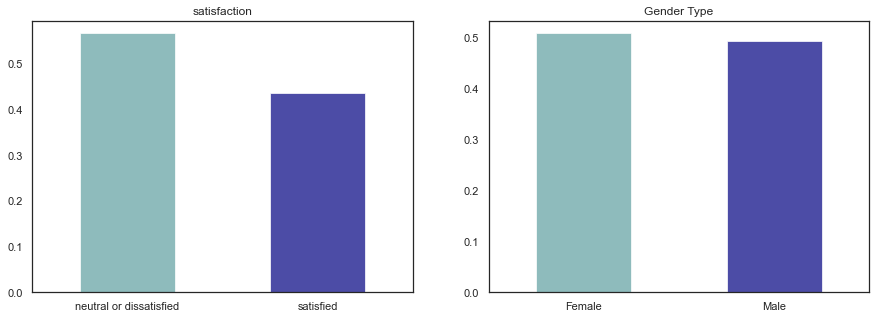

Counter({'neutral or dissatisfied': 73452, 'satisfied': 56428})
Counter({'Female': 65899, 'Male': 63981})


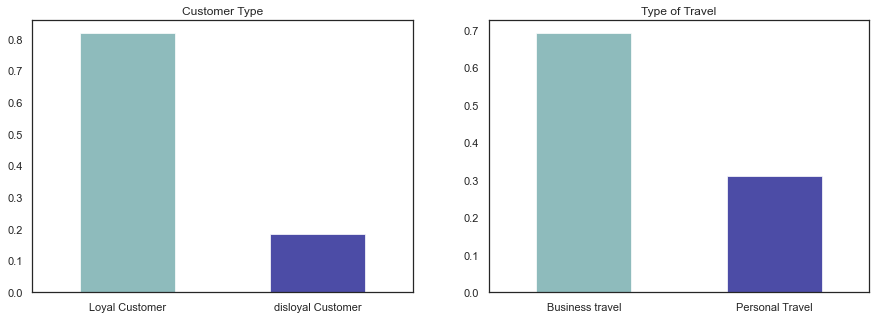

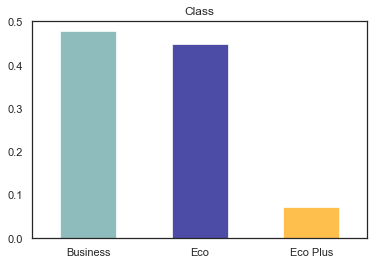

Counter({'Loyal Customer': 106100, 'disloyal Customer': 23780})
Counter({'Business travel': 89693, 'Personal Travel': 40187})
Counter({'Business': 62160, 'Eco': 58309, 'Eco Plus': 9411})


In [6]:
# Import Counter
from collections import Counter

# Create first two bar charts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1 = plt.subplot2grid((1,2),(0,0))
result['satisfaction'].value_counts(normalize = True).plot(kind='bar', color= ['cadetblue','navy'],\
                                                           alpha = 0.7, rot=0)
plt.title('satisfaction')

ax1 = plt.subplot2grid((1,2),(0,1))
result['Gender'].value_counts(normalize = True).plot(kind='bar', color= ['cadetblue','navy'],\
                                                     alpha = 0.7, rot=0)
plt.title('Gender Type')
plt.show()

print(Counter(result['satisfaction']))
print(Counter(result['Gender']))

# Create another three bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
ax1 = plt.subplot2grid((1,2),(0,0))
result['Customer Type'].value_counts(normalize = True).plot(kind='bar', color= ['cadetblue','navy'],\
                                                            alpha = 0.7, rot=0)
plt.title('Customer Type')

ax1 = plt.subplot2grid((1,2),(0,1))
result['Type of Travel'].value_counts(normalize = True).plot(kind='bar', color= ['cadetblue','navy'],\
                                                             alpha = 0.7, rot=0)
plt.title('Type of Travel')
plt.show()

result['Class'].value_counts(normalize = True).plot(kind='bar', color= ['cadetblue','navy', 'orange'],\
                                                    alpha = 0.7, rot=0)
plt.title('Class')
plt.show()

print(Counter(result['Customer Type']))
print(Counter(result['Type of Travel']))
print(Counter(result['Class']))

<a id="f"></a>
## 6| Exploratory Data Analysis (Part 3)
<p>What if we revisit <code>Gender</code>, <code>Customer Type</code>, <code>Type of Travel</code>, and <code>Class</code> based on if the passenger is <em>satisfied</em> or <em>neutral or dissatisfied</em>?</p>

<p>What stands out is passengers who were on <em>Personal Travel</em> were not satisfied. Passengers in the <em>Business</em> class were satisfied compared to the other two classes.</p>

<p></p>
<p></p>
<code></code>

<AxesSubplot:xlabel='Class', ylabel='Count'>

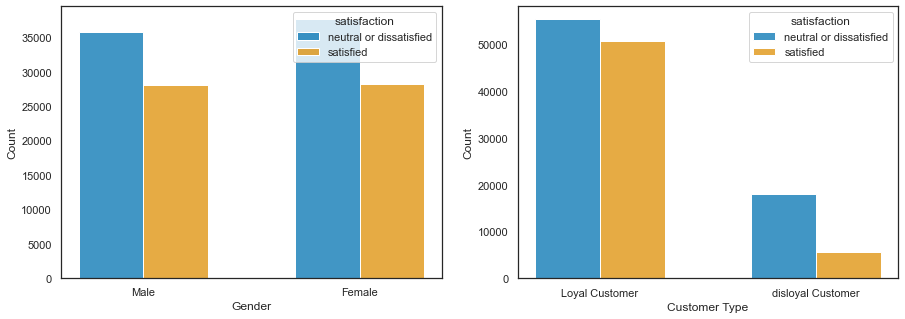

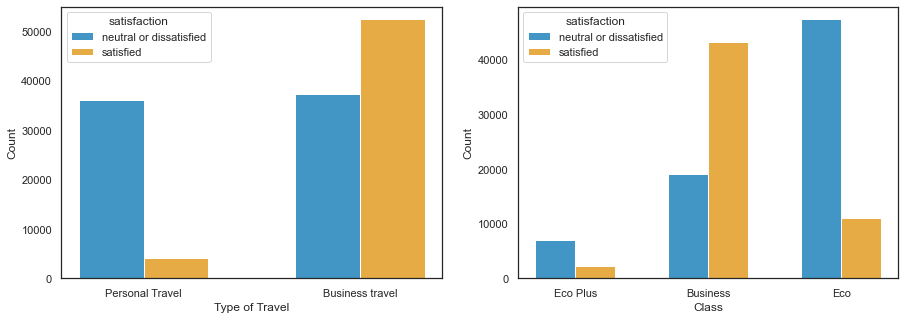

In [7]:
# Plot Gender and Customer Type bar charts
fig, ax = plt.subplots(1, 2,  figsize=(15, 5))
sns.histplot(data=result, x ='Gender', hue='satisfaction', multiple="dodge", shrink=.6, 
             palette='colorblind', ax=ax[0])
sns.histplot(data=result, x ='Customer Type', hue ='satisfaction', multiple="dodge", shrink=.6, 
             palette='colorblind', ax=ax[1])

# Plot Type of Travel and Class bar charts
fig, ax = plt.subplots(1, 2,  figsize=(15, 5))
sns.histplot(data=result, x ='Type of Travel', hue='satisfaction', multiple="dodge", shrink=.6, 
             palette='colorblind', ax=ax[0])
sns.histplot(data=result, x ='Class', hue ='satisfaction', multiple="dodge", shrink=.6, 
             palette='colorblind', ax=ax[1])

<a id="g"></a>
## 7| Exploratory Data Analysis (Part 4)
<p>Furthermore, what if we consider the features that are on the scale of 0 to 5 based on if the passenger is <em>satisfied</em> or <em>neutral or dissatisfied</em>?</p>

<p>With the exception of <code>Departure/Arrival time convenient</code> and <code>Gate location</code>, every other feature had a higher mean when the passenger felt <em>satisfied</em>.</p>

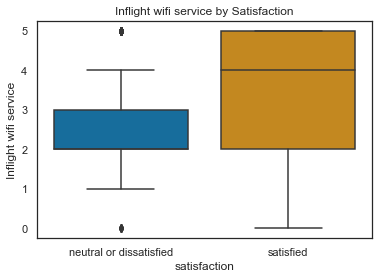

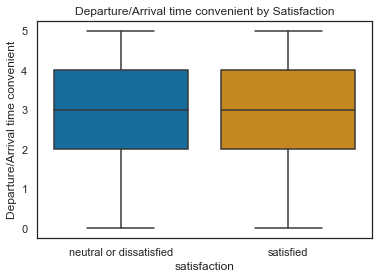

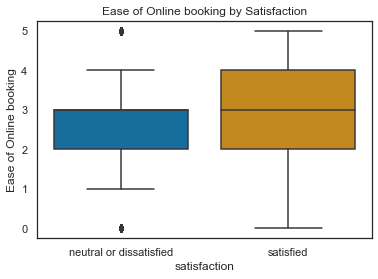

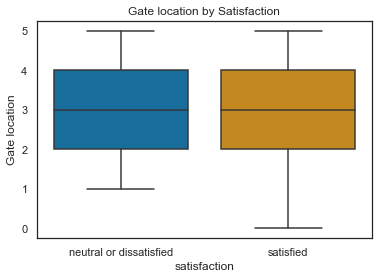

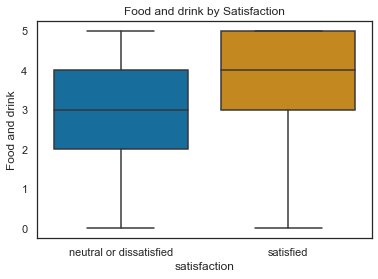

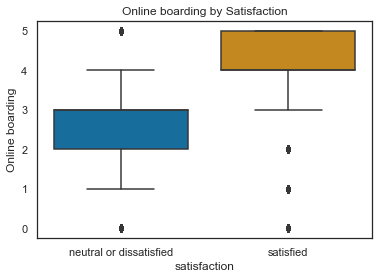

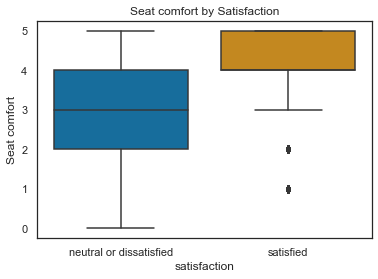

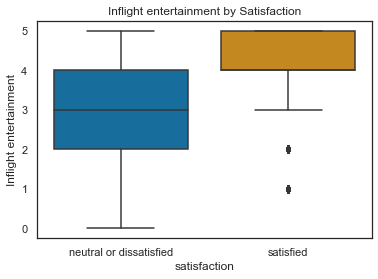

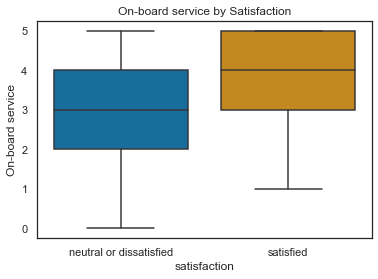

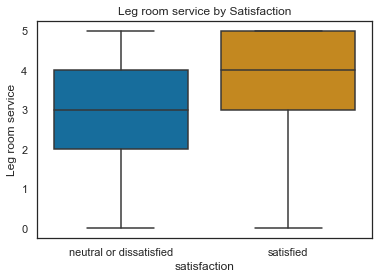

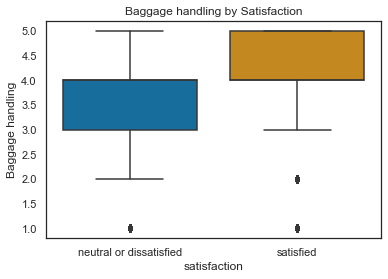

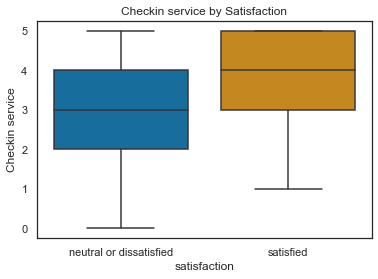

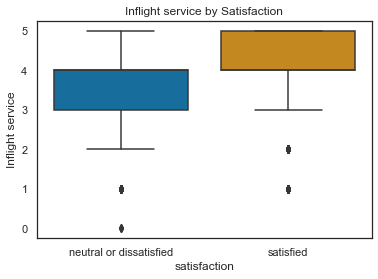

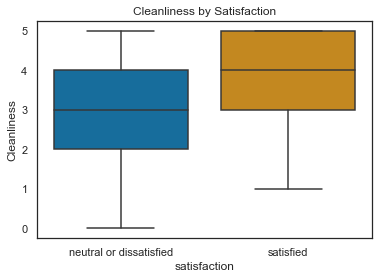

In [8]:
# Create DataFrame of categorical features that are on a scale of 0 to 5
categorical = result[['Inflight wifi service','Departure/Arrival time convenient',\
                     'Ease of Online booking','Gate location','Food and drink',\
                     'Online boarding','Seat comfort','Inflight entertainment',\
                     'On-board service','Leg room service','Baggage handling',\
                     'Checkin service','Inflight service','Cleanliness']]

# Create function to plot a series of feature distribution             
def plot_boxplot(df):
    for feature in categorical.iloc[:,:]:
        fig, axes = plt.subplots(1,1)
        sns.boxplot(data=result, x='satisfaction', y=feature, palette='colorblind')
        plt.title(f'{feature} by Satisfaction')
        plt.show()
        
plot_boxplot(categorical)

<a id="h"></a>
## 8| Preprocess the data
<p>There is still some minor but essential data preprocessing needed before we build our logistic regression model. We will be converting all the non-numeric values into numeric ones. Essentially, we will be creating dummy variables for <code>satisfaction</code>, <code>Gender</code>, <code>Customer Type</code>, <code>Type of Travel</code>, and <code>Class</code>. They will range from 0 to 1, except for <code>Class</code>, which will range from 0 to 2.</p>

In [9]:
def transform_typeoftravel(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1
    
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customertype(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco':
        return 1
    elif x == 'Eco Plus':
        return 0
    else:
        return -1
    
# Drop id column since it is not necessary
def preprocess_data(df):
    df = df.drop(['id'], axis = 1)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_typeoftravel)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customertype)
    df['Class'] = df['Class'].apply(transform_class)
    
    return df
    
result = preprocess_data(result)

<a id="i"></a>
## 9| Updated Summary
<p>We now check the values of the features to ensure nothing seems out of place. Previously, we did not have enough information on the object type features due to them not being numeric. That has changed. We know now:
<ul>
<li>51% of the passengers were female.</li>
<li>82% of passengers were loyal customers. </li>
<li>69% of travel was business.</li>
<li>43% of passengers were satisfied.</li>
</ul>

In [10]:
new_summary = result.describe(include='all')
round(new_summary, 2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00,129880.00
mean,0.51,0.82,39.43,0.69,1.41,1190.32,2.73,3.06,2.76,2.98,3.20,3.25,3.44,3.36,3.38,3.35,3.63,3.31,3.64,3.29,14.71,15.09,0.43
std,0.50,0.39,15.12,0.46,0.62,997.45,1.33,1.53,1.40,1.28,1.33,1.35,1.32,1.33,1.29,1.32,1.18,1.27,1.18,1.31,38.07,38.41,0.50
min,0.00,0.00,7.00,0.00,0.00,31.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,27.00,0.00,1.00,414.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,3.00,3.00,3.00,2.00,0.00,0.00,0.00
50%,1.00,1.00,40.00,1.00,1.00,844.00,3.00,3.00,3.00,3.00,3.00,3.00,4.00,4.00,4.00,4.00,4.00,3.00,4.00,3.00,0.00,0.00,0.00
75%,1.00,1.00,51.00,1.00,2.00,1744.00,4.00,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,4.00,5.00,4.00,5.00,4.00,12.00,13.00,1.00
max,1.00,1.00,85.00,1.00,2.00,4983.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1592.00,1584.00,1.00


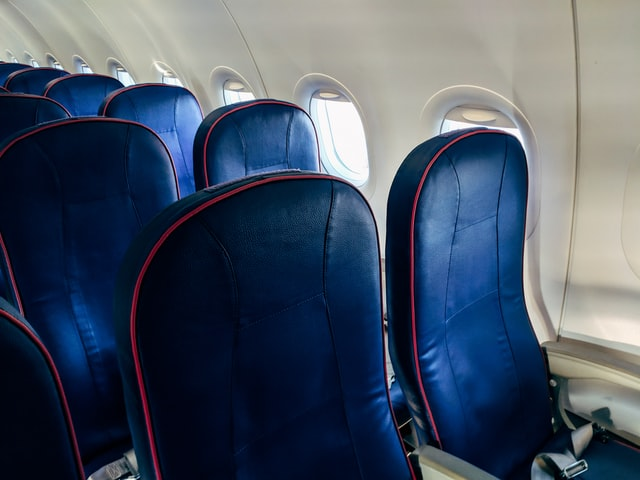
<p><font size="1.5">Photo by <a href="https://unsplash.com/@markuswinkler">Markus Winkler</a> on <a href="https://unsplash.com/photos/QT5zAH9PPo4">Unsplash</a> [3].</font></p>

<a id="j"></a>
## 10| Average Airline Passengers
<p>There are several ways to approach the marginal effects of logistic regression. One way is to calculate and report a marginal effect for an "average" individual.</p>
<p>Below is the mean response for all features.</p>
<code></code>
<code></code>

In [11]:
# Finding mean responses and situations
result.mean(axis=0)

Gender                                  0.507384
Customer Type                           0.816908
Age                                    39.427957
Type of Travel                          0.690584
Class                                   1.406136
Flight Distance                      1190.316392
Inflight wifi service                   2.728696
Departure/Arrival time convenient       3.057599
Ease of Online booking                  2.756876
Gate location                           2.976925
Food and drink                          3.204774
Online boarding                         3.252633
Seat comfort                            3.441361
Inflight entertainment                  3.358077
On-board service                        3.383023
Leg room service                        3.350878
Baggage handling                        3.632114
Checkin service                         3.306267
Inflight service                        3.642193
Cleanliness                             3.286326
Departure Delay in M

<a id="k"></a>
## 11| Median Airline Passengers
<p>Is the average individual really of interest? We run into a problem when we consider that some features are binary or discrete. Can we say we want a marginal effect of a passenger who is .69 travels business? Or a marginal effect of a passenger who chooses 1.4 class?</p>
<p>Another choice is finding the marginal effect of a median airline passenger. In other words, we are looking for the 50th percentile passenger.</p>
<code></code>
<code></code>

In [12]:
# Finding most median responses and situations
result.median(axis=0)

Gender                                 1.0
Customer Type                          1.0
Age                                   40.0
Type of Travel                         1.0
Class                                  1.0
Flight Distance                      844.0
Inflight wifi service                  3.0
Departure/Arrival time convenient      3.0
Ease of Online booking                 3.0
Gate location                          3.0
Food and drink                         3.0
Online boarding                        3.0
Seat comfort                           4.0
Inflight entertainment                 4.0
On-board service                       4.0
Leg room service                       4.0
Baggage handling                       4.0
Checkin service                        3.0
Inflight service                       4.0
Cleanliness                            3.0
Departure Delay in Minutes             0.0
Arrival Delay in Minutes               0.0
satisfaction                           0.0
dtype: floa

<a id="l"></a>
## 12| Modal Airline Passengers
<p>The modal airline passenger is our last option. In other words, they are the most common passenger we are likely to see at the airport. It makes the most sense as we can better describe the passenger and their choices. For example, a female passenger is a loyal customer, chooses business class, and scores cleanliness a 4.</p>
<p></p>
<code></code>
<code></code>

In [13]:
# Finding most common "modal" responses and situations
result.mode(axis=0)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,1,39,1,2,337,2,4,3,3,4,4,4,4,4,4,4,4,4,4,0,0.0,0


<a id="m"></a>
## 13| Correlation with satisfaction
<p>A correlation measures the strength and direction of the association of two or more variables. We want to find out how correlated the features are with satisfaction.</p>
<p><code>Online boarding</code>, <code>Class</code>, <code>Type of Travel</code>, <code>Inflight entertainment</code>, and <code>Seat comfort</code> have the highest correlation with satisfaction.</p>
<p>Surprisingly, <code>Gate location</code> has no correlation with satisfaction.</p>

<p></p>
<code></code>
<code></code>

<AxesSubplot:>

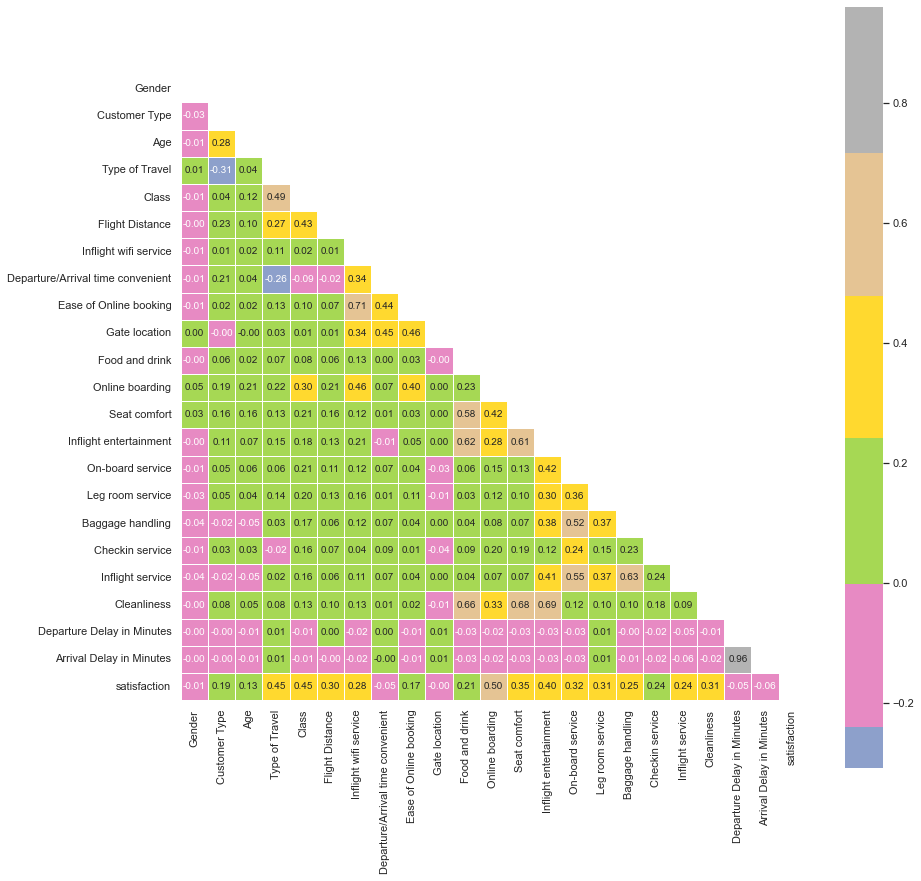

In [14]:
# Import NumPy
import numpy as np

# Create correlation 
corr = result.corr(method='pearson')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))

# Plot the correlation heatmap
sns.heatmap(corr, annot = True, mask=mask, cmap="Set2", center=0,
            square=True, linewidths=.5, fmt='.2f')

In [15]:
# List correlation with satisfaction in absolute terms
corr = round(abs(corr.satisfaction), 2)
corr.sort_values(ascending=False)

satisfaction                         1.00
Online boarding                      0.50
Class                                0.45
Type of Travel                       0.45
Inflight entertainment               0.40
Seat comfort                         0.35
On-board service                     0.32
Cleanliness                          0.31
Leg room service                     0.31
Flight Distance                      0.30
Inflight wifi service                0.28
Baggage handling                     0.25
Checkin service                      0.24
Inflight service                     0.24
Food and drink                       0.21
Customer Type                        0.19
Ease of Online booking               0.17
Age                                  0.13
Arrival Delay in Minutes             0.06
Departure/Arrival time convenient    0.05
Departure Delay in Minutes           0.05
Gender                               0.01
Gate location                        0.00
Name: satisfaction, dtype: float64

<a id="n"></a>
## 14| Setting aside mixes of features
<p>We'll test marginal effects with different sizes of features.</p>
<ul>
<li>Version 1 will use all features</li>
<li>Version 2 will use 15 features</li>
<li>Version 3 will use 10 features</li>
<li>Version 4 will use 5 features</li>
<li>Version 5 will use top 5 correlated features</li>
</ul>
<p>Machine Learning can do many things. For example, it can help select some features to use in our logistic regression model. The Scikit-learn API provides the SelectKBest class for extracting the best features of a given data set. The SelectKBest method selects the features according to the k highest score. Choosing the best features is necessary, especially when many features are involved. We'll set the 'chi2' method as a scoring function.</p>
<code></code>


In [16]:
# Import SelectKBest chi2 and array
from sklearn.feature_selection import SelectKBest, chi2
from numpy import array 

# Create X array of features
X = result.iloc[:, :-1] # Remove target variable

# Create target variable
y = result.satisfaction

# Use SelectKBest to pick 15 features based on chi2
select = SelectKBest(score_func=chi2, k=15)
f = select.fit_transform(X,y)

# Identify the selected features
filter = select.get_support()
features = array(list(X))

# Print out the best 15 features
print("Selected 15 best features:")
print(features[filter])

# Create X array with 15 best features according to SelectKBest
X_selected15 = result[['Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service',\
                       'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',\
                       'On-board service', 'Leg room service', 'Checkin service', 'Cleanliness',\
                       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

Selected 15 best features:
['Age' 'Type of Travel' 'Class' 'Flight Distance' 'Inflight wifi service'
 'Food and drink' 'Online boarding' 'Seat comfort'
 'Inflight entertainment' 'On-board service' 'Leg room service'
 'Checkin service' 'Cleanliness' 'Departure Delay in Minutes'
 'Arrival Delay in Minutes']


In [17]:
# Use SelectKBest to pick 10 features based on chi2
select = SelectKBest(score_func=chi2, k=10)
f = select.fit_transform(X,y)

# Identify the selected features
filter = select.get_support()
features = array(list(X))

# Print out the best 10 features
print("Selected 10 best features:")
print(features[filter])

# Create X array with 10 best features according to SelectKBest
X_selected10 = result[['Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service',\
                       'Online boarding', 'Seat comfort', 'Inflight entertainment','Departure Delay in Minutes',\
                       'Arrival Delay in Minutes']]

Selected 10 best features:
['Age' 'Type of Travel' 'Class' 'Flight Distance' 'Inflight wifi service'
 'Online boarding' 'Seat comfort' 'Inflight entertainment'
 'Departure Delay in Minutes' 'Arrival Delay in Minutes']


In [18]:
# Use SelectKBest to pick 5 features based on chi2
select = SelectKBest(score_func=chi2, k=5)
f = select.fit_transform(X,y)

# Identify the selected features
filter = select.get_support()
features = array(list(X))

# Print out the best 15 features
print("Selected 5 best features:")
print(features[filter])

# Create X array with 5 best features according to SelectKBest
X_selected5 = result[['Age', 'Flight Distance', 'Online boarding', 'Departure Delay in Minutes',\
                       'Arrival Delay in Minutes']]

Selected 5 best features:
['Age' 'Flight Distance' 'Online boarding' 'Departure Delay in Minutes'
 'Arrival Delay in Minutes']


In [19]:
# Create X arrary of top 5 correlated features with satisfaction
X_correlated5 = result[['Online boarding','Class','Type of Travel','Inflight entertainment','Seat comfort']]

<a id="o"></a>
## 15| Splitting the data into X and y
<p>One last step is we're going to add a constant term to the regression, and we do that by using the statsmodels library.</p>
<p></p>
<code></code>
<code></code>

In [20]:
# Import statsmodels
import statsmodels.api as sm

# Add constant
X = sm.add_constant(X)

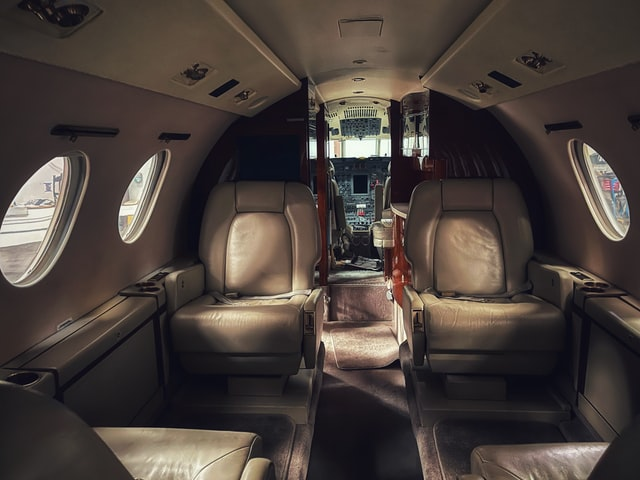
<p><font size="1.5">Photo by <a href="https://unsplash.com/@yaro_muzychenko">Yaroslav Muzychenko</a> on <a href="https://unsplash.com/photos/cp3hc2N39WA">Unsplash</a> [4].</font></p>

<a id="p"></a>
## 16| Fitting the Logistic Regression model
<p>Time to get a model! Again, we have 22 features in the X array. How do these features affect satisfaction? At this moment, we cannot tell the marginal effects. Still, we can know if they impact satisfaction negatively or positively.</p>

<p>Wow! Every feature is statistically significant meaning its p-value is less than 0.05 except <code>flight distance</code>. Moreover, <code>Gender</code>, <code>Age</code>, <code>Departure/Arrival time convenient</code>, <code>Ease of Online booking</code>, <code>Food and drink</code>, <code>Arrival Delay in Minutes</code> all have a negative impact on satisfaction. That means that as one these features increases, satisfaction decreases.</p>
<p>Our investigation in marginal effects is now approaching.</p>
<code></code><code></code><code></code><code></code><code></code>
<code></code>

In [21]:
# Create model
logit = sm.Logit(y, X)

# Fit the model
result = logit.fit()

# See results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.335295
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               129880
Model:                          Logit   Df Residuals:                   129857
Method:                           MLE   Df Model:                           22
Date:                Sat, 16 Jul 2022   Pseudo R-squ.:                  0.5102
Time:                        14:17:48   Log-Likelihood:                -43548.
converged:                       True   LL-Null:                       -88907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               -11.7920      0.076   -155

<a id="q"></a>
## 17| Mean Marginal Effects
<p>Our first attempt at understanding marginal effects is here. We are using the mean of each feature. </p>
<p>As previously noted, the sign of each feature has not changed. If the feature had a positive sign before, it still does in its marginal effect.</p>
<p>If we look at the <code>Type of Travel</code>, a one unit change in the type of travel from personal to business travel increases the likelihood of satisfaction by 66.88%.</p>
<p>There is still the issue that some features are not continuous or binary. For example, <code>Food and drink</code> are discrete. Let's hop over to notice median marginal effects.</p>
<code></code><code></code><code></code><code></code><code></code>
<code></code>

In [22]:
# Get marginal effects at the mean of all features
mfx = result.get_margeff(at='mean')

# See marginal effects estimates results
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:           satisfaction
Method:                          dydx
At:                              mean
                                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Gender                               -0.0144      0.004     -3.524      0.000      -0.022      -0.006
Customer Type                         0.4906      0.006     78.520      0.000       0.478       0.503
Age                                  -0.0020      0.000    -13.239      0.000      -0.002      -0.002
Type of Travel                        0.6688      0.006    106.928      0.000       0.657       0.681
Class                                 0.1210      0.004     30.262      0.000       0.113       0.129
Flight Distance                   -3.906e-07   2.36e-06     -0.166      0.868   -5.01e-06    4.23e-06
Inflight wifi service           

<a id="r"></a>
## 18| Median Marginal Effects
<p>Whoops! Statsmodels does not allow us to use median marginal effects if we have discrete features. We reach the last stop, which is modal marginal effects.</p>
<code></code><code></code><code></code><code></code><code></code>
<code></code>

In [23]:
# Get marginal effects at the median
# mfx_median = result.get_margeff(at='median', dummy=True)

# See marginal effects estimates results
# print(mfx_median.summary())

<a id="s"></a>
## 19| Modal Marginal Effects
<p>With this version of marginal effects, we allow the continuous variables to be at the mean while the binary and discrete variables are at the mode. By accounting for the differences, we are getting a better estimate.</p>
<p>Previously a one unit change in <code>Type of Travel</code> from personal to business travel increased the likelihood of satisfaction by 66.88%, but now it is 51.57%.</p>
<code></code>



In [24]:
# Get marginal effects at the mean for continous variables
# and at the mode for binary and discrete
mfx = result.get_margeff(at='mean',dummy=True)

# See marginal effects estimates results
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:           satisfaction
Method:                          dydx
At:                              mean
                                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Gender                               -0.0144      0.004     -3.524      0.000      -0.022      -0.006
Customer Type                         0.3713      0.003    108.908      0.000       0.365       0.378
Age                                  -0.0020      0.000    -13.239      0.000      -0.002      -0.002
Type of Travel                        0.5157      0.003    149.263      0.000       0.509       0.522
Class                                 0.1210      0.004     30.262      0.000       0.113       0.129
Flight Distance                   -3.906e-07   2.36e-06     -0.166      0.868   -5.01e-06    4.23e-06
Inflight wifi service           

<a id="t"></a>
## 20| Confidence in Marginal Effect estimation
<p>We will verify that the estimates hold by multiplying them by their maximum value on the survey. They should be bounded between -1 and 1. We will use <code>Type of Travel</code>, <code>Flight Distance</code>, <code>Inflight wifi service</code>, <code>Seat comfort</code>, and <code>Cleanliness</code> as our sample.</p>

         

In [25]:
# Marginal effects of sample variables

mfx_typeoftravel = 0.5157
mfx_flightdistance = -0.0000003906
mfx_inflightwifi = 0.0930
mfx_seatcomfort = 0.0160
mfx_cleanliness = 0.0538

This means a one unit change in <code>Type of Travel</code> from personal to business travel increases the likelihood of satisfaction by 51.57%. A one air mile change in the <code>Flight Distance</code> decreases the likelihood of satisfaction by -0.00003906%. A one unit score change in the <code>Inflight wifi service</code> increases the likelihood of satisfaction by 9.30%. A one unit score change in <code>Seat comfort</code> increases the likelihood of satisfaction by 1.60%. A one unit score change in <code>cleanliness</code> increases the likelihood of satisfaction by 5.38%. 

In [26]:
# Calculate max mfx of flight distance
max_flightdistance_mfx = mfx_flightdistance * 4983

# Calculate max mfx of type of travel
max_typeoftravel_mfx = mfx_typeoftravel * 1

# Calculate max mfx of flight distance
max_inflightwifi_mfx = mfx_inflightwifi * 5

# Calculate max mfx of flight distance
max_seatcomfort_mfx = mfx_seatcomfort * 5

# Calculate max mfx of flight distance
max_cleanliness_mfx = mfx_cleanliness * 5

# Calculate marginal effect difference between most and least flight distance
diff = (mfx_flightdistance * 4983) - (mfx_flightdistance * 31)

# Print values of maximum marginal effects
print("The marginal effect of flight distance between the shortest and the longest flight is:", diff)
print("Max mfx of flight distance:", max_flightdistance_mfx)
print("Max mfx of type of travel:", max_typeoftravel_mfx)
print("Max mfx of inflight wifi:", max_inflightwifi_mfx)
print("Max mfx of seat comfort:", max_seatcomfort_mfx)
print("Max mfx of cleanliness:", max_cleanliness_mfx)

The marginal effect of flight distance between the shortest and the longest flight is: -0.0019342512
Max mfx of flight distance: -0.0019463598
Max mfx of type of travel: 0.5157
Max mfx of inflight wifi: 0.46499999999999997
Max mfx of seat comfort: 0.08
Max mfx of cleanliness: 0.269


<p>These variables are within their limits! We can trust the calculations.</p>

<a id="u"></a>
## 21| Version 2: 15 features
<p>We have an excellent model when we use all features! <code>Flight Distance</code> is the only variable that is not statistically significant. Previously, we had created X arrays with different amounts of features and we're testing those out now. Version 2 of the logistic regression model has 15 features selected by SelectKBest from Scikit-learn.</p>
<p>We have to load up the original data sets and preprocess them again to make a new logistic regression when we use the statsmodels library. The function all_prep that we created helps us reduce the amount of code needed to test the versions.</p>
<p>What's changed is the sign of many features. <code>Flight Distance</code> is now positive.  <code>Inflight wifi service</code>, <code>Seat comfort</code>, <code>On-board service</code>, <code>Leg room service</code>, and <code>Clealiness</code> are now negative. <code>Type of Travel</code> now only increases the likelyhood of satisfaction by 26.58%, which is about half of version one.</p>
<p></p>
<code></code>

In [27]:
def all_prep():
    # Load the two datasets
    df1 = pd.read_csv('train.csv')
    df2 = pd.read_csv('test.csv')

    # Remove the first columns
    df1 = df1.iloc[: , 1:]
    df2 = df2.iloc[: , 1:]

    # Append the DataFrames
    result = pd.concat([df1, df2])

    # Reset the index and have it start at 1
    result.reset_index(drop=True,inplace=True)
    result.index += 1

    # Impute the missing values with mean imputation
    result['Arrival Delay in Minutes'].fillna(result['Arrival Delay in Minutes'].mean(), inplace=True)
    
    def transform_typeoftravel(x):
        if x == 'Business travel':
            return 1
        elif x == 'Personal Travel':
            return 0
        else:
            return -1

    def transform_satisfaction(x):
        if x == 'satisfied':
            return 1
        elif x == 'neutral or dissatisfied':
            return 0
        else:
            return -1

    def transform_gender(x):
        if x == 'Female':
            return 1
        elif x == 'Male':
            return 0
        else:
            return -1

    def transform_customertype(x):
        if x == 'Loyal Customer':
            return 1
        elif x == 'disloyal Customer':
            return 0
        else:
            return -1

    def transform_class(x):
        if x == 'Business':
            return 2
        elif x == 'Eco':
            return 1
        elif x == 'Eco Plus':
            return 0
        else:
            return -1

    # Drop id column since it is not necessary
    def preprocess_data(df):
        df = df.drop(['id'], axis = 1)
        df['Type of Travel'] = df['Type of Travel'].apply(transform_typeoftravel)
        df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
        df['Gender'] = df['Gender'].apply(transform_gender)
        df['Customer Type'] = df['Customer Type'].apply(transform_customertype)
        df['Class'] = df['Class'].apply(transform_class)

        return df

    # Run preproccesing function
    result = preprocess_data(result)

    # Create X array of features
    X = result.iloc[:, :-1] # Remove target variable

    # Create target variable
    y = result.satisfaction

    # Add constant
    X = sm.add_constant(X)

In [28]:
# Call all_prep function
all_prep()

# Create model
logit_15= sm.Logit(y, X_selected15)

# Fit the model
result_15 = logit_15.fit()

# See results
print(result_15.summary())

# Get marginal effects at the mean for continous variables
# and at the mode for binary and discrete
mfx_15 = result_15.get_margeff(at='mean',dummy=True)

# See marginal effects estimates results
print(mfx_15.summary())

Optimization terminated successfully.
         Current function value: 0.565361
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               129880
Model:                          Logit   Df Residuals:                   129865
Method:                           MLE   Df Model:                           14
Date:                Sat, 16 Jul 2022   Pseudo R-squ.:                  0.1741
Time:                        14:17:50   Log-Likelihood:                -73429.
converged:                       True   LL-Null:                       -88907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Age                           -0.0366      0.000    -85.179      0.000      

<a id="v"></a>
## 22| Version 3: 10 features
<p>Version 3 of the logistic regression model has 10 features selected by SelectKBest from Scikit-learn. The function all_prep is doing a lot of work in the background.</p>

<p><code>Type of Travel</code> is weaker than before. <code>Online boarding</code> plays a large impact. A score of 5 increases the likelyhood of satisfaction by 62.8%.</p>

<p></p>
<code></code>

In [29]:
# Call all_prep function
all_prep()

# Create model
logit_10 = sm.Logit(y, X_selected10)

# Fit the model
result_10 = logit_10.fit()

# See results
print(result_10.summary())

# Get marginal effects at the mean for continous variables
# and at the mode for binary and discrete
mfx_10 = result_10.get_margeff(at='mean',dummy=True)

# See marginal effects estimates results
print(mfx_10.summary())

Optimization terminated successfully.
         Current function value: 0.594007
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               129880
Model:                          Logit   Df Residuals:                   129870
Method:                           MLE   Df Model:                            9
Date:                Sat, 16 Jul 2022   Pseudo R-squ.:                  0.1322
Time:                        14:17:51   Log-Likelihood:                -77150.
converged:                       True   LL-Null:                       -88907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Age                           -0.0402      0.000    -98.521      0.000      

<a id="w"></a>
## 23| Version 4: 5 features
<p>Version 4 of the logistic regression model has 5 features selected by SelectKBest from Scikit-learn. <code>Online boarding</code>  has the potential to influence satisfaction the most. The other 4 features have a minuscule impact.</p>

<p></p>
<code></code>

In [30]:
# Call all_prep function
all_prep()

# Create model
logit_5 = sm.Logit(y, X_selected5)

# Fit the model
result_5 = logit_5.fit()

# See results
print(result_5.summary())

# Get marginal effects at the mean for continous variables
# and at the mode for binary and discrete
mfx_5 = result_5.get_margeff(at='mean',dummy=True)

# See marginal effects estimates results
print(mfx_5.summary())

Optimization terminated successfully.
         Current function value: 0.627968
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               129880
Model:                          Logit   Df Residuals:                   129875
Method:                           MLE   Df Model:                            4
Date:                Sat, 16 Jul 2022   Pseudo R-squ.:                 0.08263
Time:                        14:17:52   Log-Likelihood:                -81561.
converged:                       True   LL-Null:                       -88907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Age                           -0.0374      0.000   -106.440      0.000      

<a id="x"></a>
## 24| Version 5: Top 5 correlations
<p>Version 5 of the logistic regression model has 5 features selected by the highest correlation with satisfaction. An increase in <code>Class</code> and <code>Seat comfort</code> decreases the likelihood of satisfaction.</p>

<p></p>
<code></code>

In [31]:
# Call all_prep function
all_prep()

# Create model
logit_correlated5 = sm.Logit(y, X_correlated5)

# Fit the model
result_correlated5 = logit_correlated5.fit()

# See results
print(result_correlated5.summary())

# Get marginal effects at the mean for continous variables
# and at the mode for binary and discrete
mfx_correlated5 = result_correlated5.get_margeff(at='mean',dummy=True)

# See marginal effects estimates results
print(mfx_correlated5.summary())

Optimization terminated successfully.
         Current function value: 0.659197
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               129880
Model:                          Logit   Df Residuals:                   129875
Method:                           MLE   Df Model:                            4
Date:                Sat, 16 Jul 2022   Pseudo R-squ.:                 0.03701
Time:                        14:17:53   Log-Likelihood:                -85616.
converged:                       True   LL-Null:                       -88907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Online boarding            0.1937      0.005     40.751      0.000       0.184      

<a id="y"></a>
## 25| Conclusion

<p>What shocked me was that the logistic regression model with all the features did the best job estimating the marginal effects on satisfaction. This model only had one feature that was not statistically significant. I also agree with the signs of the features the most with this model. Visually exploring gender showed that a more considerable proportion of females felt <em>neutral or dissatisfied</em> compared to males. An increase in the <code>Arrival Delay in Minutes</code> should decrease satisfaction. <code>Age</code>, <code>Departure/Arrival time convenient</code>, <code>Departure/Arrival time convenient</code>, <code>Food and drink</code> I am not too sure about. Those features could be further explored down the line.</p>

## References

<p>[1] Photo by <a href="https://unsplash.com/@by_syeoni">Suhyeon Choi</a> on <a href="https://unsplash.com/photos/tTfDMaRq-FE">Unsplash</a>, (2017)</p>
<p>[2] Photo by <a href="https://unsplash.com/@alschim">Alexander Schimmeck</a> on <a href="https://unsplash.com/photos/HcI3I8mTaQU">Unsplash</a>, (2021)</p>
<p>[3] Photo by <a href="https://unsplash.com/@markuswinkler">Markus Winkler</a> on <a href="https://unsplash.com/photos/QT5zAH9PPo4">Unsplash</a>, (2019)</p>
<p>[4] Photo by <a href="https://unsplash.com/@yaro_muzychenko">Yaroslav Muzychenko</a> on <a href="https://unsplash.com/photos/cp3hc2N39WA">Unsplash</a>, (2021)</p>
<p></p>